In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmasher as cmr

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_174738/1060579645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [3]:
#Cargando los datos de TW, SH y T
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)
seas=xr.concat(da_list,dim='estacion')

In [5]:
#Cargando los datos de los clústers
cluster=pd.read_csv("clustering_Had.csv")

In [6]:
#Separando cada clúster
cluster0=cluster.loc[cluster.cluster==0]
cluster1=cluster.loc[cluster.cluster==1]

In [7]:
#Seleccionamos el id para el clúster 0, costero
Id=cluster0["ID"]
#Seleccionamos id para el clúster 1,continental
Id1=cluster1["ID"]

#Seleccionamos dichos ID dentro de todos nuestros datos
Datos=seas.where(seas.estacion.isin(Id),drop=True) #Cluster0
Datos1=seas.where(seas.estacion.isin(Id1),drop=True) #Cluster1


In [14]:
#Separando los años de estudio para el clúster costero
#El primer periodo será de 1979 al 2000

#Seleccionamos el primer periodo de tiempo
mask1=(Datos.time.dt.year>=1979) & (Datos.time.dt.year<=2000)
P1_clus0=Datos.where(mask1,drop=True)

#Seleccionamos el segundo periodo de tiempo
mask2=(Datos.time.dt.year>=2001)
P2_clus0=Datos.where(mask2,drop=True)

In [15]:
#Realizando el ciclo anual para el clúster costero
#Periodo1
Mes=(P1_clus0.resample(time="ME").mean()).groupby("time.month").mean()
annual1_clus0=Mes.mean("estacion")

#Periodo1
Mes1=(P2_clus0.resample(time="ME").mean()).groupby("time.month").mean()
annual2_clus0=Mes1.mean("estacion")

In [16]:
#Separando los años de estudio para el clúster continental
#El primer periodo será de 1979 al 2000

#Seleccionamos el primer periodo de tiempo
mask_c=(Datos1.time.dt.year>=1979) & (Datos1.time.dt.year<=2000)
P1_clus1=Datos1.where(mask_c,drop=True)

#Seleccionamos el segundo periodo de tiempo
mask_c1=(Datos1.time.dt.year>=2001)
P2_clus1=Datos1.where(mask_c1,drop=True)

In [17]:
#Realizando el ciclo anual para el clúster continental
#Periodo0
Mes_c=(P1_clus1.resample(time="ME").mean()).groupby("time.month").mean()
annual1_clus1=Mes_c.mean("estacion")

#Periodo1
Mes_c1=(P2_clus1.resample(time="ME").mean()).groupby("time.month").mean()
annual2_clus1=Mes_c1.mean("estacion")

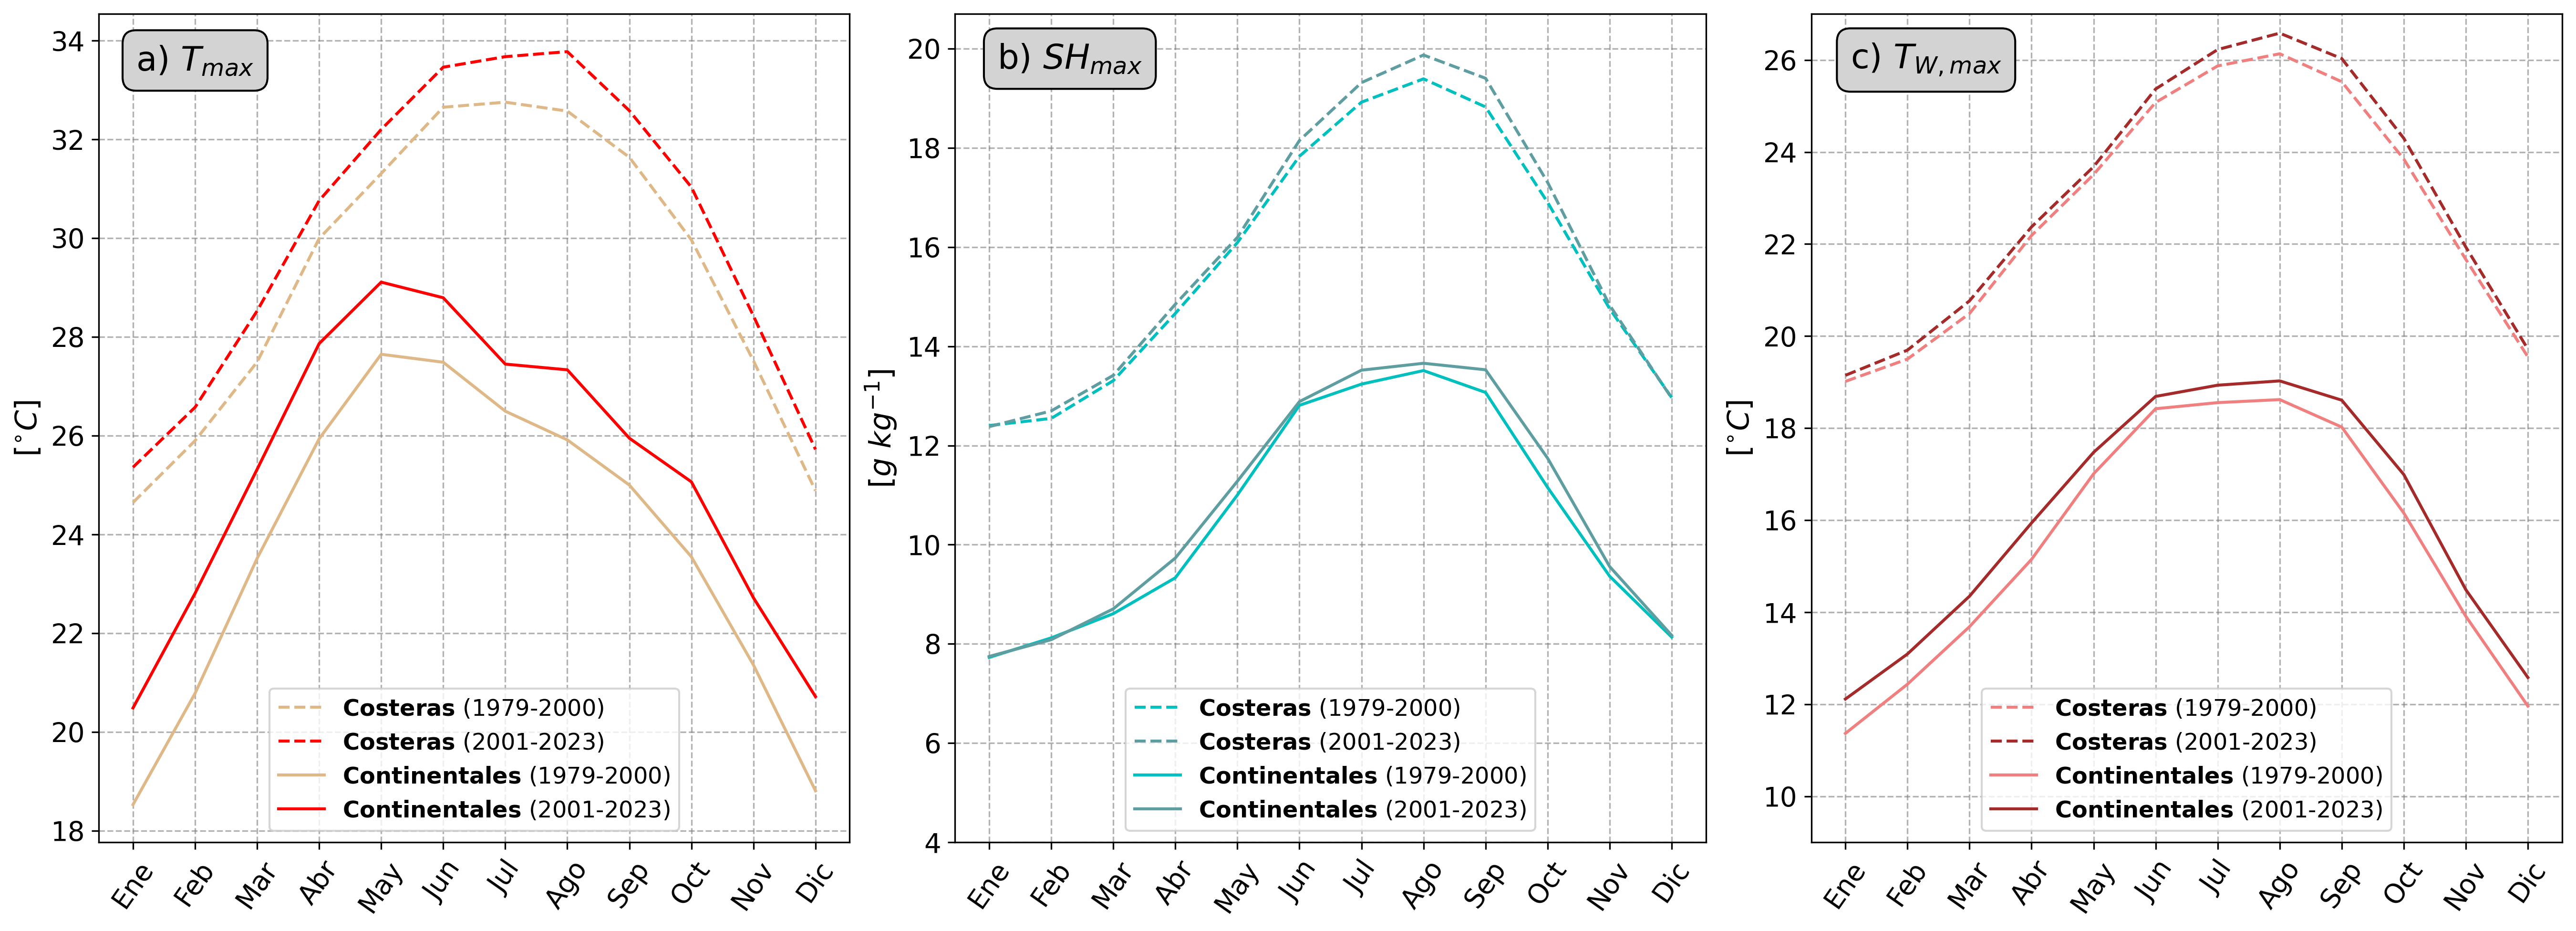

In [19]:
#Graficando en multipanel de las 6 variables

fig = plt.figure(figsize=(18,6.5),dpi=300)
meses=['Ene','Feb','Mar','Abr','May','Jun','Jul', 'Ago','Sep','Oct','Nov','Dic']
variables=["Tmax","SHmax","Twmax"]
datos=["a)","b)","c)"]
labels=["[$^{\circ}C$]","[$g$ $kg^{-1}$]","[$^{\circ}C$]"]
color=["#DEB887","red","#00BFBF","#5F9EA0","#F08080","#A52A2A"]
linestyles=["--","-"]

for ivar,var in enumerate(variables): 
    if var=="Twmax":
        plt.subplot(1,3,3)
        plt.plot(meses,annual1_clus0[var]-273.15,linestyle=linestyles[0],color=color[4],label=r"$\mathbf{Costeras}$ (1979-2000)")
        plt.plot(meses,annual2_clus0[var]-273.15,linestyle=linestyles[0],color=color[5],label=r"$\mathbf{Costeras}$ (2001-2023)")
        plt.plot(meses,annual1_clus1[var]-273.15,linestyle=linestyles[1],color=color[4],label=r"$\mathbf{Continentales}$ (1979-2000)")
        plt.plot(meses,annual2_clus1[var]-273.15,linestyle=linestyles[1],color=color[5],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylim(9,27)
        #plt.axhline(y=35,c='red',linewidth=3)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1.3, 26, "c) $T_{W,max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=11.5)
       
        
    elif var=="SHmax":
        plt.subplot(1,3,2)
        plt.plot(meses,annual1_clus0[var]*1000,linestyle=linestyles[0],color=color[2],label=r"$\mathbf{Costeras}$ (1979-2000)")
        plt.plot(meses,annual2_clus0[var]*1000,linestyle=linestyles[0],color=color[3],label=r"$\mathbf{Costeras}$ (2001-2023)")
        plt.plot(meses,annual1_clus1[var]*1000,linestyle=linestyles[1],color=color[2],label=r"$\mathbf{Continentales}$ (1979-2000)")
        plt.plot(meses,annual2_clus1[var]*1000,linestyle=linestyles[1],color=color[3],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylim(4,20.7)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1.3, 19.8, "b) $SH_{max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=11.5,loc="lower center")
       

    else:
        plt.subplot(1,3,1)
        a,=plt.plot(meses,annual1_clus0[var],linestyle=linestyles[0],color=color[0],label=r"$\mathbf{Costeras}$ (1979-2000)")
        b,=plt.plot(meses,annual2_clus0[var],linestyle=linestyles[0],color=color[1],label=r"$\mathbf{Costeras}$ (2001-2023)")
        c,=plt.plot(meses,annual1_clus1[var],linestyle=linestyles[1],color=color[0],label=r"$\mathbf{Continentales}$ (1979-2000)")
        d,=plt.plot(meses,annual2_clus1[var],linestyle=linestyles[1],color=color[1],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1, 33.6, "a) $T_{max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)  
        plt.legend(fontsize=11.5)
plt.tight_layout(pad=0.7)
        
        
plt.savefig("Ciclo_anual_porclusteryperiodo.svg",bbox_inches="tight",dpi=300)      
plt.savefig("Ciclo_anual_porclusteryperiodo.png",bbox_inches="tight",dpi=300)    

